downlaod from fashion MNIST  
```
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
```
put them into data/fashion

In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/fashion', one_hot=True)

Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


In [4]:
img, label = mnist.train.next_batch(10)

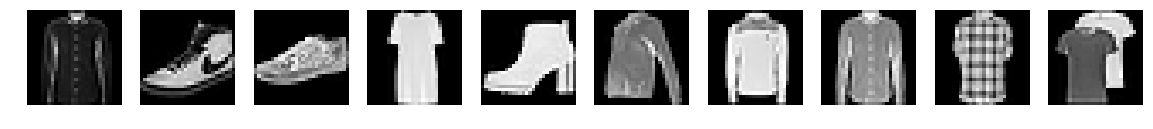

In [5]:
dim = 28
fig, axs = plt.subplots(1, len(img), figsize=(20, 3))
for i, m in enumerate(img):
        axs[i].imshow(np.reshape(m, (dim, dim)),cmap='gray')
        axs[i].axis('off')
plt.show()

In [28]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)

def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)

def conv2d(x, filt):
    """
    x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
    filt is a filter. W.shape is [filter_height, filter_width, in_channels, out_channels]
    """
    return tf.nn.conv2d(x, filt, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def batch_normalization(x):
    """
      x -> γ(x-μ)/√（σ^2-ε）　+ β
      
      γ : scale
      μ: mean (first moment)
      σ: variance (second moment)
      β: offset
      ε: to avoid dividing by 0
    """
    epsilon = 1e-5
    dim = x.get_shape()[-1]
    scale = tf.Variable(tf.ones([dim]))
    offset = tf.Variable(tf.zeros([dim]))
    mean, variance = tf.nn.moments(x, [0,1,2])
    return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

def variable_summaries(var):  
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [41]:
def build_graph(learning_rate, bn=True):
    height = 28
    width = 28
    image_size = height * width

    tf.reset_default_graph()
    with tf.Graph().as_default() as g1:
        with tf.name_scope('input'):
            x = tf.placeholder(tf.float32, shape=[None, image_size], name='x-input')
            y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')
            keep_prob = tf.placeholder(tf.float32, name="dropout-input")

        with tf.name_scope('input_reshape'):    
            x_image = tf.reshape(x, [-1, height, width, 1])
            tf.summary.image('input',  x_image, 10)

        with tf.name_scope("conv1"):
            with tf.name_scope('weights'):
                W_conv1 = weight_variable([5,5,1,32])
                variable_summaries(W_conv1)        
            with tf.name_scope('biases'):
                b_conv1 = bias_variable([32])
                variable_summaries(b_conv1)
            h_conv1 = conv2d(x_image, W_conv1) + b_conv1
            variable_summaries(h_conv1)
        
        if bn:
            with tf.name_scope("batch_norm1"):
                h_conv1_bn = batch_normalization(h_conv1)
        else:
                h_conv1_bn = h_conv1
            
        with tf.name_scope("relu1"):
            h_conv1_act = tf.nn.relu(h_conv1_bn)

        with tf.name_scope("pool1"):   
            h_pool1 = max_pool_2x2(h_conv1_act)
            variable_summaries(h_pool1)

        with tf.name_scope("conv2"):
            with tf.name_scope('weights'):
                W_conv2 = weight_variable([5,5,32,64])
                variable_summaries(W_conv2) 
            with tf.name_scope('biases'):    
                b_conv2 = bias_variable([64])
                variable_summaries(b_conv2)
            h_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
            variable_summaries(h_conv2)
        
        if bn:
            with tf.name_scope("batch_norm2"):
                h_conv2_bn = batch_normalization(h_conv2)
        else:
                h_conv2_bn = h_conv2

        with tf.name_scope("relu2"):
            h_conv2_act = tf.nn.relu(h_conv2_bn)

        with tf.name_scope("pool2"):
            h_pool2 = max_pool_2x2(h_conv2_act)
            variable_summaries(h_pool2)

        with tf.name_scope("pool2_flat"):
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

        with tf.name_scope("fc1"):
            with tf.name_scope('weights'):
                W_fc1 = weight_variable([7 * 7 * 64, 1024])
            with tf.name_scope('biases'):   
                b_fc1 = bias_variable([1024])
            h_fc1 =tf.matmul(h_pool2_flat, W_fc1) + b_fc1

        with tf.name_scope("relu3"):
            h_fc1_act = tf.nn.relu(h_fc1)

        with tf.name_scope("dropout"):
            h_fc1_drop = tf.nn.dropout(h_fc1_act, keep_prob)

        with tf.name_scope("fc2"):
            with tf.name_scope('weights'):
                W_fc2 = weight_variable([1024,10])
            with tf.name_scope('biases'): 
                b_fc2 = bias_variable([10]) 
            y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

        with tf.name_scope("loss"):
            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
            tf.summary.scalar('cross_entropy', loss)
     
        with tf.name_scope("optimizer_1"):
                opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        with tf.name_scope("accuracy"):
            correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
            tf.summary.scalar('accuracy', accuracy)
    
    res = {
        "g": g1,
        "x": x,
        "y": y_,
        "keep_prob": keep_prob,
        "loss": loss,
        "acc": accuracy,
        "opt": opt
    }
    return res

In [39]:
g = build_graph(True)["g"]
import tensorboard as tb 
tb.show_graph(g)

In [50]:
n_iter = 50000
batch_size = 50

test_info = [
    {"name":"bn_3","dir": "logs/bn3", "batch_norm": True, "learning_rate": 1.0e-3},
    {"name":"nobn_3","dir": "logs/nobn3", "batch_norm": False, "learning_rate": 1.0e-3},
    {"name":"bn_2","dir": "logs/bn2", "batch_norm": True, "learning_rate": 1.0e-2},
    {"name":"nobn_2","dir": "logs/nobn2", "batch_norm": False, "learning_rate": 1.0e-2},
]

log_dir = "logs"
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

tensorboard_dir = ",".join([d["name"]+":"+d["dir"] for d in test_info]) 
print("tensorboard --logdir="+tensorboard_dir)

for info in test_info:  
    
    res = build_graph(info["learning_rate"], info["batch_norm"])
    tb.show_graph(res["g"])
    with tf.Session(graph=res["g"]) as sess:
        sess.run(tf.global_variables_initializer())
        opt = res["opt"]
        x = res["x"]
        y_ = res["y"]
        loss = res["loss"]
        accuracy = res["acc"]
        keep_prob =res["keep_prob"]
    
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(info["dir"] + '/train', sess.graph)
        test_writer = tf.summary.FileWriter(info["dir"]+ '/test')
    
        for i in tqdm(range(n_iter)):
            batch = mnist.train.next_batch(batch_size)
            _ = sess.run(opt, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.6})
        
            if i % 100 == 0 and i != 0:
                train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={
                      x: batch[0], y_: batch[1], keep_prob: 1.0})
                print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
                train_writer.add_summary(summary, i)
        
        test_accuracy, test_summary, = sess.run([accuracy, merged], 
                                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
        test_writer.add_summary(test_summary, 0)
        print('test accuracy %g' % test_accuracy)

tensorboard --logdir=bn_3:logs/bn3,nobn_3:logs/nobn3,bn_2:logs/bn2,nobn_2:logs/nobn2


A Jupyter Widget


step 100, training loss 0.583949, training accuracy 0.76
step 200, training loss 0.363956, training accuracy 0.9
step 300, training loss 0.417141, training accuracy 0.82
step 400, training loss 0.412246, training accuracy 0.86
step 500, training loss 0.269525, training accuracy 0.94
step 600, training loss 0.373314, training accuracy 0.86
step 700, training loss 0.328138, training accuracy 0.86
step 800, training loss 0.382635, training accuracy 0.84
step 900, training loss 0.342922, training accuracy 0.9
step 1000, training loss 0.365206, training accuracy 0.86
step 1100, training loss 0.398191, training accuracy 0.84
step 1200, training loss 0.344057, training accuracy 0.88
step 1300, training loss 0.212169, training accuracy 0.94
step 1400, training loss 0.156384, training accuracy 0.94
step 1500, training loss 0.257767, training accuracy 0.88
step 1600, training loss 0.307178, training accuracy 0.92
step 1700, training loss 0.434795, training accuracy 0.82
step 1800, training loss

A Jupyter Widget

step 100, training loss 0.460004, training accuracy 0.84
step 200, training loss 0.499825, training accuracy 0.82
step 300, training loss 0.324233, training accuracy 0.92
step 400, training loss 0.3781, training accuracy 0.82
step 500, training loss 0.375357, training accuracy 0.82
step 600, training loss 0.191568, training accuracy 0.96
step 700, training loss 0.283885, training accuracy 0.94
step 800, training loss 0.198005, training accuracy 0.94
step 900, training loss 0.220456, training accuracy 0.9
step 1000, training loss 0.308402, training accuracy 0.9
step 1100, training loss 0.317398, training accuracy 0.9
step 1200, training loss 0.166367, training accuracy 0.94
step 1300, training loss 0.192013, training accuracy 0.96
step 1400, training loss 0.312677, training accuracy 0.88
step 1500, training loss 0.218053, training accuracy 0.92
step 1600, training loss 0.206418, training accuracy 0.9
step 1700, training loss 0.217005, training accuracy 0.84
step 1800, training loss 0.16

A Jupyter Widget

step 100, training loss 0.62161, training accuracy 0.76
step 200, training loss 0.603214, training accuracy 0.74
step 300, training loss 0.337887, training accuracy 0.9
step 400, training loss 0.452974, training accuracy 0.76
step 500, training loss 0.357566, training accuracy 0.92
step 600, training loss 0.523416, training accuracy 0.8
step 700, training loss 0.554172, training accuracy 0.74
step 800, training loss 0.446348, training accuracy 0.82
step 900, training loss 0.247118, training accuracy 0.9
step 1000, training loss 0.224199, training accuracy 0.92
step 1100, training loss 0.482339, training accuracy 0.82
step 1200, training loss 0.63164, training accuracy 0.78
step 1300, training loss 0.364028, training accuracy 0.86
step 1400, training loss 0.322722, training accuracy 0.92
step 1500, training loss 0.417996, training accuracy 0.82
step 1600, training loss 0.534106, training accuracy 0.82
step 1700, training loss 0.287613, training accuracy 0.88
step 1800, training loss 0.2

A Jupyter Widget

step 100, training loss 1.0169, training accuracy 0.56
step 200, training loss 0.715333, training accuracy 0.74
step 300, training loss 0.611291, training accuracy 0.76
step 400, training loss 0.29986, training accuracy 0.92
step 500, training loss 0.622942, training accuracy 0.78
step 600, training loss 0.469939, training accuracy 0.82
step 700, training loss 0.35927, training accuracy 0.84
step 800, training loss 0.812341, training accuracy 0.76
step 900, training loss 0.271345, training accuracy 0.9
step 1000, training loss 0.553171, training accuracy 0.84
step 1100, training loss 0.26054, training accuracy 0.88
step 1200, training loss 0.449869, training accuracy 0.9
step 1300, training loss 0.299754, training accuracy 0.94
step 1400, training loss 0.48259, training accuracy 0.84
step 1500, training loss 0.50078, training accuracy 0.84
step 1600, training loss 0.393879, training accuracy 0.82
step 1700, training loss 0.354946, training accuracy 0.88
step 1800, training loss 0.37073